# 时间序列模型
时间序列模型主要分为四种：自回归模型AR，移动回归模型MA，两种的结合移动自回归模型ARMA，以及差分移动自回归模型ARIMA

## AR模型
因变量能由它的多个滞后项表示称为自回归模型（AR）。  
p阶自回归模型可以写成：
$$x_t=\phi_0+\phi_1x_{t-1}+\phi_2x_{t-2}+...+\phi_px_{t-p}+\mu_t$$
$x_{t-p}是x_t的滞后p阶，\phi_p为自回归系数，\mu_t为白噪音，满足标准正态分布$。  

模拟一个AR(1)模型，让 $\phi_{0}为零， \phi_{1}$ 等于0.8

In [61]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt     
#tsa为Time Series analysis缩写
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
#画图
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [63]:
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):   
        data = pd.Series(data)
    #matplotlib官方提供了五种不同的图形风格，
    #包括bmh、ggplot、dark_background、fivethirtyeight和grayscale
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'时序图')
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')        
        scs.probplot(data, sparams=(data.mean(), data.std()), plot=pp_ax)
        pp_ax.set_title('PP 图') 
        plt.tight_layout()
    return

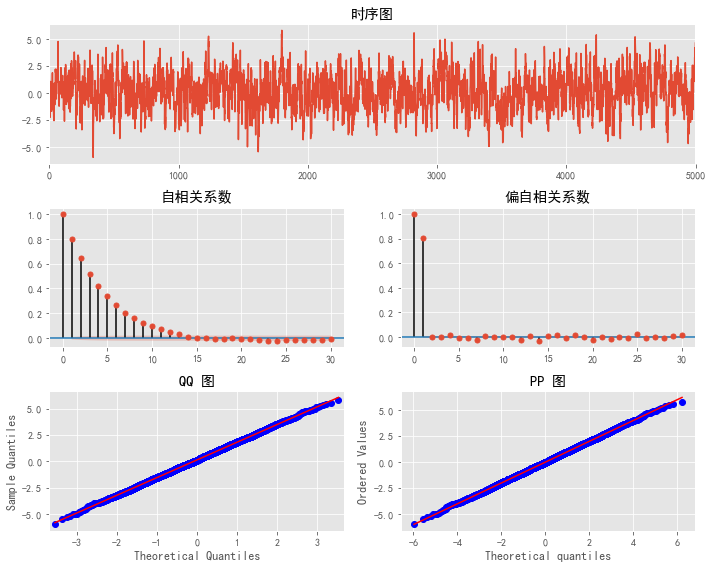

In [64]:
# 模拟AR(1) 过程 
#设置随机种子（括号里数字无意义）
np.random.seed(1)
#模拟次数
n=5000
#AR模型的参数
a = 0.8
#扰动项为正态分布
x = w = np.random.normal(size=n)
for t in range(1,n):
    x[t] = a*x[t-1] + w[t]
#画图
ts_plot(x, lags=30)

模拟的AR(1)模型是正态的。自相关系数图（ACF）显示滞后值之间存在显著的序列相关性，偏自相关系数图（PACF）则显示在滞后1期时截尾（迅速降为0）。下面使用statsmodels构建AR(p)模型,先用AR模型拟合上述模拟的数据，并返回估计的系数参数（$\phi$），然后选择最佳滞后阶数，最后与原模型设置对比看是否选择了正确的滞后项。假如AR模型是正确的，那估计的系数参数将很接近真实的系数0.8，选择的阶数也会等于1。

In [65]:
#估计数据的AR模型参数和滞后阶数
def simu_ar(data,a,maxlag=30,true_order = 1):
    '''data:要拟合的数据；a为参数,可以为列表；maxlag:最大滞后阶数'''
    # 拟合AR(p)模型
    result = smt.AR(data).fit(maxlag=maxlag, ic='aic', trend='nc')
    #选择滞后阶数
    est_order = smt.AR(data).select_order(maxlag=maxlag, ic='aic', trend='nc')  
    #参数选择标准ic : 有四个选择 {‘aic’,’bic’,’hqic’,’t-stat’}
    #趋势项：trend：c是指包含常数项，nc为不含常数项
    #打印结果
    print(f'参数估计值：{result.params.round(2)}，估计的滞后阶数：{est_order}')
    print(f'真实参数值：{a}，真实滞后阶数 {true_order}')

In [66]:
simu_ar(x,a=0.8)

参数估计值：[0.8]，估计的滞后阶数：1
真实参数值：0.8，真实滞后阶数 1


看下如何用AR(p)模型来拟合沪深300的对数收益

沪深300拟合AR模型的参数：[ 0.03 -0.03  0.03  0.05  0.   -0.06  0.04  0.01  0.02  0.01  0.02  0.02
  0.06 -0.03  0.05]
沪深300拟合AR模型的最佳滞后阶数 15


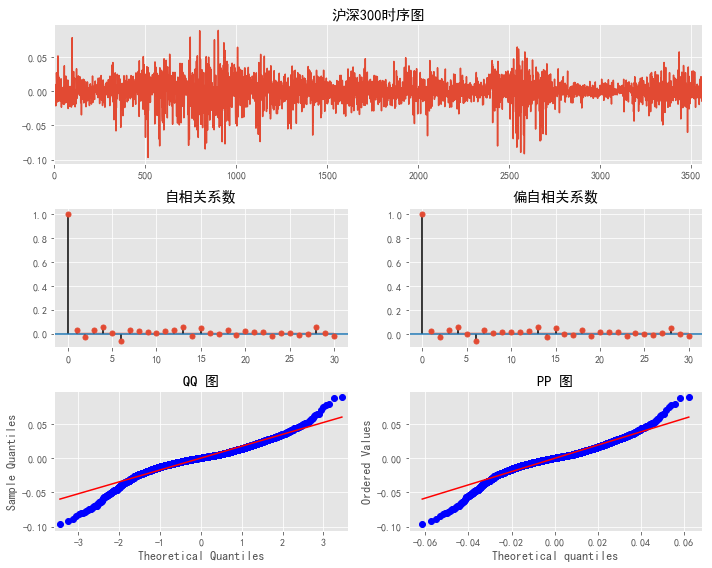

In [67]:
# Select best lag order for hs300 returns
import tushare as ts
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
pro=ts.pro_api(token)
df=pro.index_daily(ts_code='000300.SH')
df.index=pd.to_datetime(df.trade_date)
del df.index.name
df=df.sort_index()
df['ret']=np.log(df.close/df.close.shift(1))
max_lag = 30
Y=df.ret.dropna().values
ts_plot(Y,lags=max_lag,title='沪深300')
result = smt.AR(Y).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(Y).select_order(maxlag=max_lag, ic='aic', trend='nc')
print(f'沪深300拟合AR模型的参数：{result.params.round(2)}')
print(f'沪深300拟合AR模型的最佳滞后阶数 {est_order}')

最好的阶数选择是15或者有15个参数！任何模型有这么参数在实际中不可能有用。显然有比这个模型更复杂的模型可以解释

## MA模型
MA(q)模型与AR(p)模型非常相似。不同之处在于，MA(q)模型是对过去的白噪声误差项的线性组合，而不是过去观测的线性组合。MA模型的动机是我们可以直接通过拟合误差项的模型来观察误差过程中的“冲击”。在一个AR(p)模型中，通过在一系列过去的观察中使用ACF间接观察到这些冲击。MA(q)模型的公式是：

$$x_{t}=c_{0}+\omega _{t}+\beta _{1}\omega _{t-1}+...+\beta _{p}\omega _{t-p}$$

$\omega 是白噪声， E(\omega_{t})=0 ，方差是 \sigma_{a}^{2} $。  
让我们使用beta=0.6模拟这个过程。

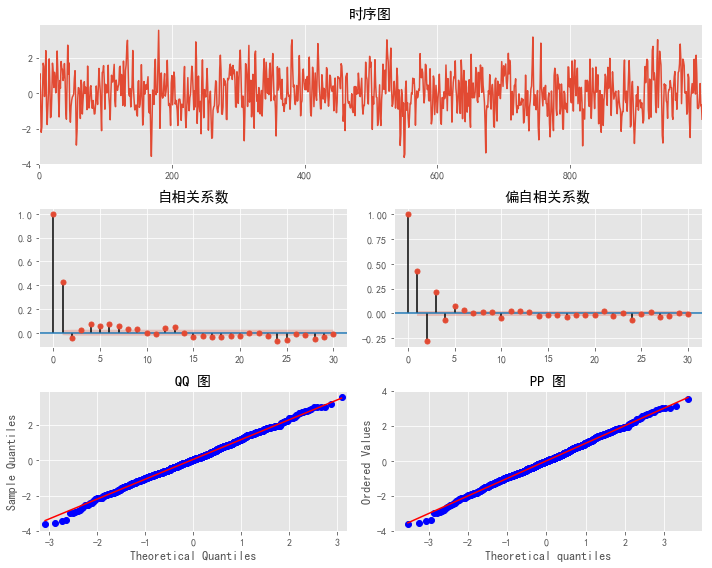

In [50]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
ts_plot(ma1, lags=30)

ACF函数表明滞后1是显着的，这表明MA（1）模型可能适合我们的模拟系列。但PACF在滞后2，3和4时的显著性不知道什么鬼，当ACF仅在滞后1时显示重要性。

In [52]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1368.563
Method:                           mle   S.D. of innovations              0.951
Date:                Mon, 26 Aug 2019   AIC                           2741.126
Time:                        17:31:55   BIC                           2750.942
Sample:                             0   HQIC                          2744.857
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6277      0.024     26.112      0.000       0.581       0.675
                                    Roots                                    
                  Real          Imaginary           M

该模型能够正确估计滞后系数，0.6277接近我们的0.6的真实值。另请注意，我们的95％置信区间确实包含真实值。让我们尝试模拟一个MA（3）过程，然后用我们的ARMA函数将三阶MA模型拟合到这个序列中，看看我们是否可以恢复正确的滞后系数（beta）。 Betas 1-3分别等于0.6,0.4和0.2。

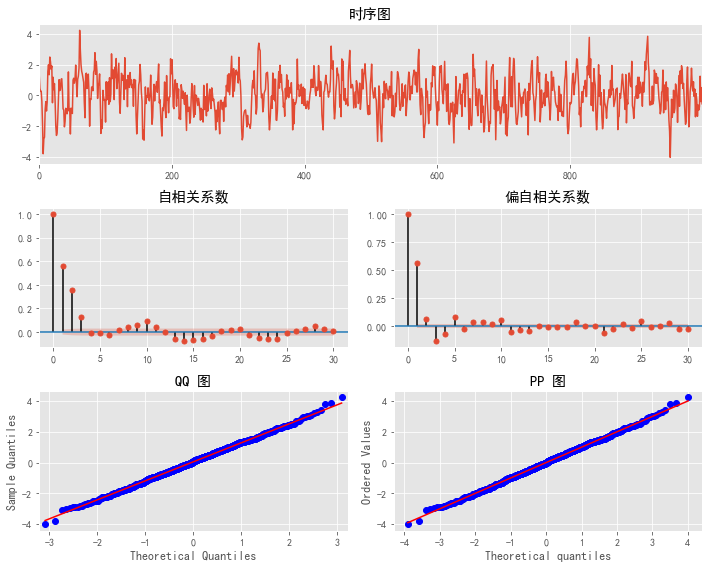

In [54]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
ts_plot(ma3, lags=30)

In [55]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1430.095
Method:                           mle   S.D. of innovations              1.011
Date:                Mon, 26 Aug 2019   AIC                           2868.191
Time:                        17:32:40   BIC                           2887.822
Sample:                             0   HQIC                          2875.652
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5282      0.031     16.895      0.000       0.467       0.589
ma.L2.y        0.4174      0.032     13.051      0.000       0.355       0.480
ma.L3.y        0.1894      0.032      5.934      0.0

可以看到模型能到有效的估计真实系数。95％置信区间确实包含真实值。现在让我们用MA(3)模型去拟合沪深300股价的对数收益。记住我们不知道真实的参数值。

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3560
Model:                     ARMA(0, 3)   Log Likelihood                9368.738
Method:                           mle   S.D. of innovations              0.017
Date:                Mon, 26 Aug 2019   AIC                         -18729.475
Time:                        17:34:33   BIC                         -18704.765
Sample:                             0   HQIC                        -18720.664
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.0248      0.017      1.473      0.141      -0.008       0.058
ma.L2.y       -0.0273      0.016     -1.705      0.088      -0.059       0.004
ma.L3.y        0.0341      0.018      1.889      0.0

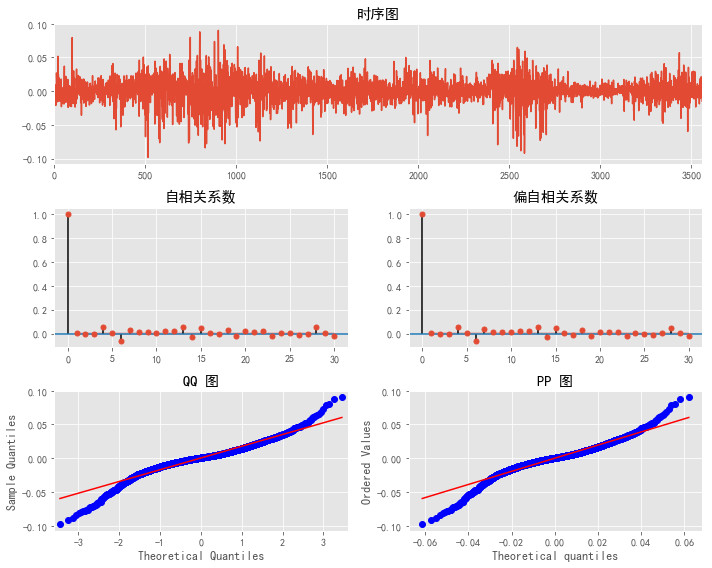

In [56]:
max_lag = 30
mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
ts_plot(mdl.resid, lags=max_lag)

还不错。ACF的某些滞后性尤其在4,6，13和15时尤为突出。它可能是抽样误差，但由于厚尾使我认为这不是预测未来SPY回报的最佳模型。

MA(q)模型：$$ x_{t}=c_{0}+\omega _{t}+\beta _{1}\omega _{t-1}+...+\beta _{p}\omega _{t-p} $$  
用了过去q个时期的随机干扰或预测误差来线性表达当前的预测值。  
平稳性：MA模型总是弱平稳的，因为他们是白噪声序列（残差序列）的有限线性组合。因此，根据弱平稳的性质可以得出两个结论：  
$E(x_{t})=c_{0} Var(x_{t})=(1+\beta_{1}^{2}+\beta_{2}^{2}+..+\beta_{p}^{2})\sigma_{a}^{2} $自相关函数：对q阶的MA模型，其自相关函数ACF总是q步截尾的。因此MA(q)序列只与其前q个延迟值线性相关，从而它是一个“有限记忆”的模型。这一点可以用来确定模型的阶次。  
可逆性：当满足可逆条件的时候，MA(q)模型可以改写为AR(p)模型。这里不进行推导，给出1阶和2阶MA的可逆性条件。  
一阶： $|\theta_{1}<1| $  
二阶： $|\theta_{2}<1| , \theta_{1}+\theta_{2}<1$

## ARMA模型
自回归移动平均模型Autoregressive Moving Average Models - ARMA(p, q)  

ARMA模型仅仅是AR（p）和MA（q）模型之间的合并。让我们从量化金融的角度回顾这些模型对我们来说代表什么：

1. AR（p）模型试图捕捉（解释）交易市场中经常观察到的动量和均值回复效应。  
2. MA（q）模型尝试捕捉（解释）在白噪声条件下观察到的冲击效应。这些冲击效应可以被认为是影响观察过程的意外事件，例如，恐怖袭击  

ARMA模型的弱点在于忽视了大多数金融时间序列中的波动聚集效应。

模型的公式是:

$$x_{t}=\alpha_{0}+\alpha_{1}x_{t-1}+\alpha_{2}x_{t-2}+...+\omega_{t}+\beta _{1}\omega _{t-1}+\beta _{2}\omega _{t-2}+...+\beta _{q}\omega _{t-q}=\alpha _{0}+\sum_{i=1}^{p}\alpha _{i}x_{t-i}+\omega _{t}+\sum_{i=1}^{q}\beta _{i}\omega _{t-i}$$

让我们给定参数去模拟一个ARMA(2, 2)过程，然后用ARMA(2, 2)模型去拟合看是否能正确估计出这些变量。让$\alpha$等于[0.5,-0.25]，$\beta$等于 [0.5,-0.3]。

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7102.555
Method:                           mle   S.D. of innovations              1.001
Date:                Mon, 26 Aug 2019   AIC                          14215.109
Time:                        17:37:48   BIC                          14247.695
Sample:                             0   HQIC                         14226.530
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.3466      0.056      6.177      0.000       0.237       0.457
ar.L2.y       -0.2560      0.015    -16.870      0.000      -0.286      -0.226
ma.L1.y        0.6576      0.057     11.440      0.0

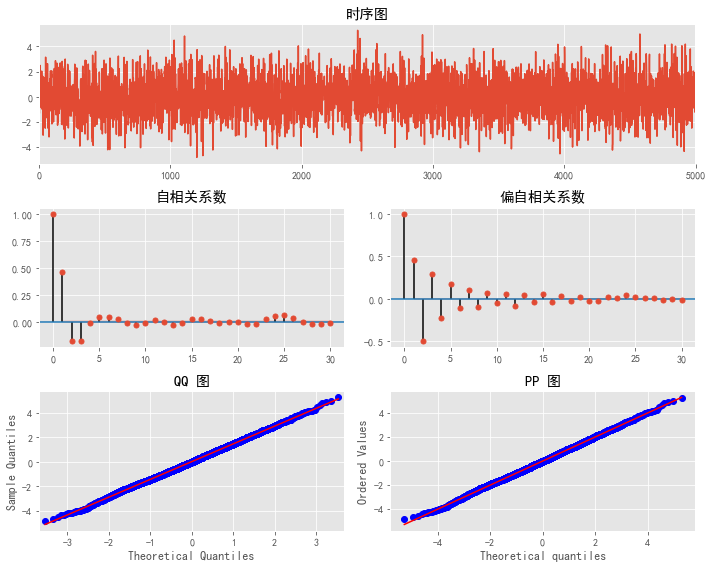

In [57]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

#burnin: to reduce the effect of initial conditions, burnin observations at the beginning of the sample are dropped
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = ts_plot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

模型正确地恢复了我们的参数，并且我们的真实参数包含在95％置信区间内。

接下来我们模拟一个ARMA（3,2）模型。之后，我们通过p，q的参数组合来循环将ARMA模型拟合到我们的模拟序列。我们根据哪个模型产生最低的AIC来选择最佳组合。

aic: 14233.88242 | order: (3, 2)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7110.941
Method:                           mle   S.D. of innovations              1.003
Date:                Mon, 26 Aug 2019   AIC                          14233.882
Time:                        17:40:15   BIC                          14272.986
Sample:                             0   HQIC                         14247.587
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5086      0.032     16.112      0.000       0.447       0.571
ar.L2.y       -0.2448      0.016    -15.137      0.000      -0.277      -0.213
ar.L3.y        0.39

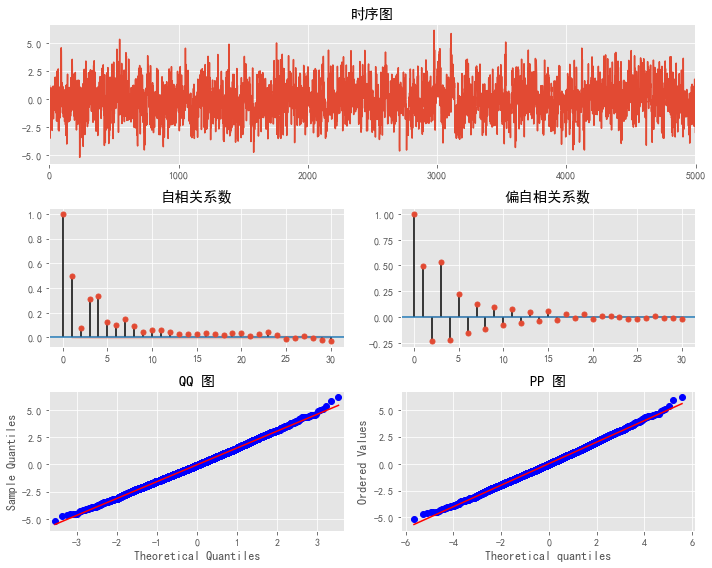

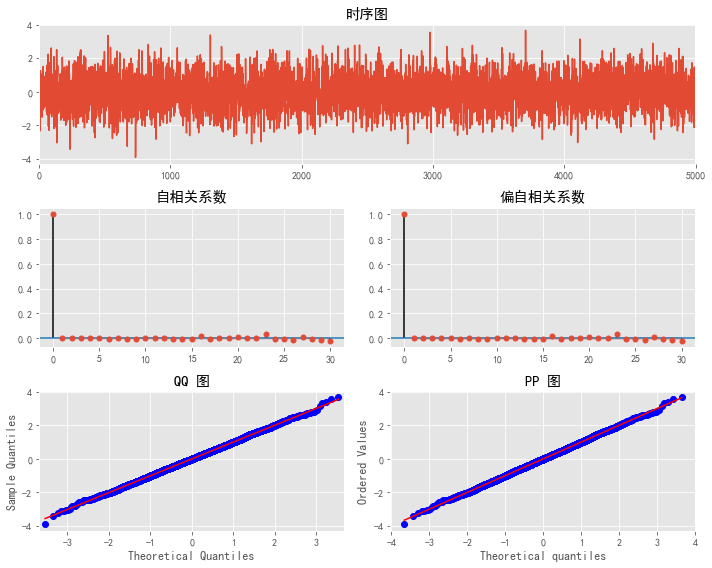

In [58]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30
n = int(5000)
burn = 2000
alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = ts_plot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())
ts_plot(best_mdl.resid, lags=max_lag)

接下来我们用ARMA去拟合沪深300的收益：

aic: -18752.93281 | order: (4, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3560
Model:                     ARMA(4, 4)   Log Likelihood                9385.466
Method:                           mle   S.D. of innovations              0.017
Date:                Mon, 26 Aug 2019   AIC                         -18752.933
Time:                        17:41:49   BIC                         -18697.335
Sample:                             0   HQIC                        -18733.108
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.2370      0.090      2.642      0.008       0.061       0.413
ar.L2.y       -0.0579      0.114     -0.508      0.612      -0.282       0.166
ar.L3.y       -0.0

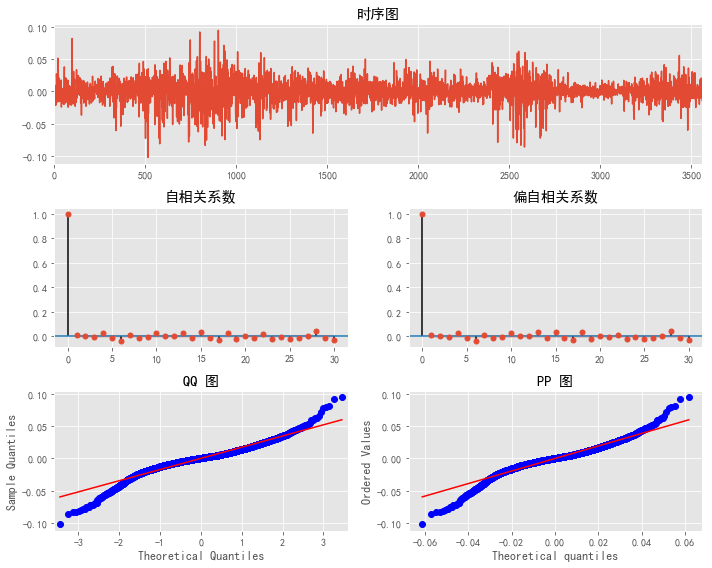

In [60]:
# Fit ARMA model to HS300 returns
best_aic = np.inf 
best_order = None
best_mdl = None
rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(Y, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())
ts_plot(best_mdl.resid, lags=30)

ACF和PACF没有显示出明显的自相关性。QQ和概率图显示残差大致为正态且厚尾。但是，这个模型的残差看起来不像白噪声！看模型没有捕捉到的明显的条件异方差（条件波动性）的突出区域。

## ARIMA模型
Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)  

ARIMA是ARMA模型的延伸。如前所述，我们的许多时间序列不是平稳的，但是它们可以通过差分来实现平稳。我们看到了一个例，当我们对高斯随机游走进行一阶差分后证明它等于白噪声。换言之，我们通过一阶差分将非平稳机游走其转化为平稳的白噪声。

差分移动自回归模型，由于前三个模型都有时间序列平稳的假设在，如果时间序列存在明显的上升或者下降趋势，模型预测的效果大大折扣，对于这些有明显下降或者上升趋势的数据集，可以使用差分的方式使它们平稳，之后使用ARMA拟合。假设模型经过d次差分通过了时间序列平稳的检验，ARMA的系数为p，q，ARIMA模型为ARIMA(p，d，q）。  

在Python中，如果我们需要不止一次的差分一个时间系列，我们必须使用np.diff（）函数。Pandas里的DataFrame.diff（）/ Series.diff（）仅能差分一次，不能实现时间序列的递归差分。

在下面的例子中，我们迭代（p，d，q）不同组合，找到拟合沪深300收益的最佳ARIMA模型。我们使用AIC来评估每个模型。选取最小的AIC。

aic: -18419.37745 | order: (4, 0, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3503
Model:                     ARMA(4, 4)   Log Likelihood                9218.689
Method:                           mle   S.D. of innovations              0.017
Date:                Thu, 06 Jun 2019   AIC                         -18419.377
Time:                        16:05:28   BIC                         -18363.925
Sample:                             0   HQIC                        -18399.588
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.2326      0.094      2.487      0.013       0.049       0.416
ar.L2.y       -0.0516      0.121     -0.425      0.671      -0.290       0.186
ar.L3.y       -

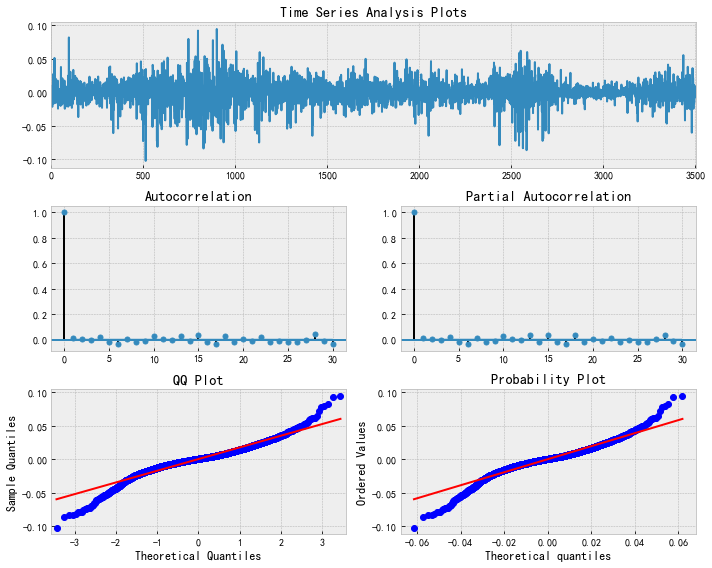

In [121]:
# Fit ARIMA(p, d, q) model to HS300 Returns
# pick best order and final model based on aic
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(logret.values, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
print(best_mdl.summary())
_ = tsplot(best_mdl.resid, lags=30)

最好的模型差分为0不足为奇。回想一下，我们已经采用了第一次对数差分来计算股票收益率。绘制模型残差，结果与我们上面所适用的ARMA（4，3）模型基本相同。显然，这个ARIMA模型并没有解释时间序列中的条件波动性！

现在我们至少有足够的知识来对未来回报进行简单的预测。这里我们利用我们模型的forecast()方法。forecast()参数里，预测的时间步数需要一个整数，而alpha参数的小数点指定置信区间。默认设置是95％的置信度。99％的阿尔法等于0.01【(1 - alpha) %】。

In [205]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

cal=pro.trade_cal(exchange='', start_date=df.index[-1])
idx = cal[cal.is_open==1][:21]['cal_date'].values
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
20190606,0.001931,-0.032195,-0.042918,0.036057,0.046781
20190610,0.000703,-0.033426,-0.044150,0.034832,0.045557
20190611,-0.001545,-0.035696,-0.046427,0.032606,0.043338
20190612,-0.001434,-0.035611,-0.046349,0.032742,0.043481
20190613,0.001269,-0.032916,-0.043658,0.035455,0.046196


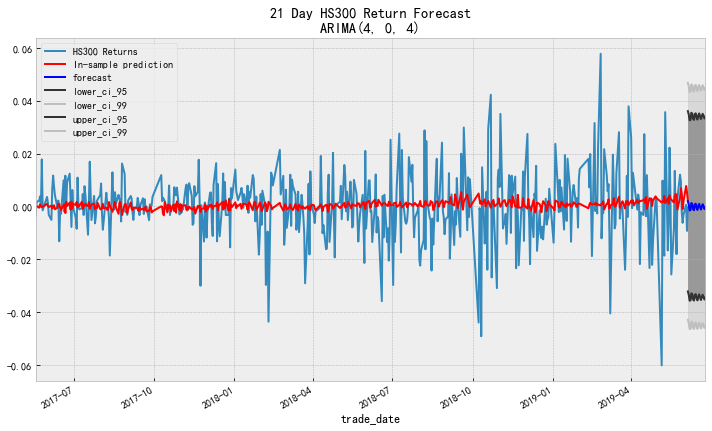

In [197]:
# Plot 21 day forecast for HS300 returns

plt.style.use('bmh')
fig = plt.figure(figsize=(12,7))
ax = plt.gca()

ts = logret[-500:].copy()
ts.plot(ax=ax, label='HS300 Returns')
# in sample prediction
pred = best_mdl.predict(np.arange(len(ts))[0], np.arange(len(ts))[-1])
pf=pd.Series(pred,index=ts.index)
pf.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day HS300 Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)
plt.show()

## ARCH模型
Autoregressive Conditionally Heteroskedastic Models - ARCH(p)  
$$Var(y_t|y_{t-1})=\sigma_t^2=\alpha_0+\alpha_1y_{t-1}^2$$

假设该时间序列均值为0，则模型可以表达为：  
$$y_t=\sigma_t\varepsilon_t, \sigma_t=\sqrt{\alpha_0+\alpha_1y_{t-1}^2},\varepsilon_t \sim iid(0,1)$$

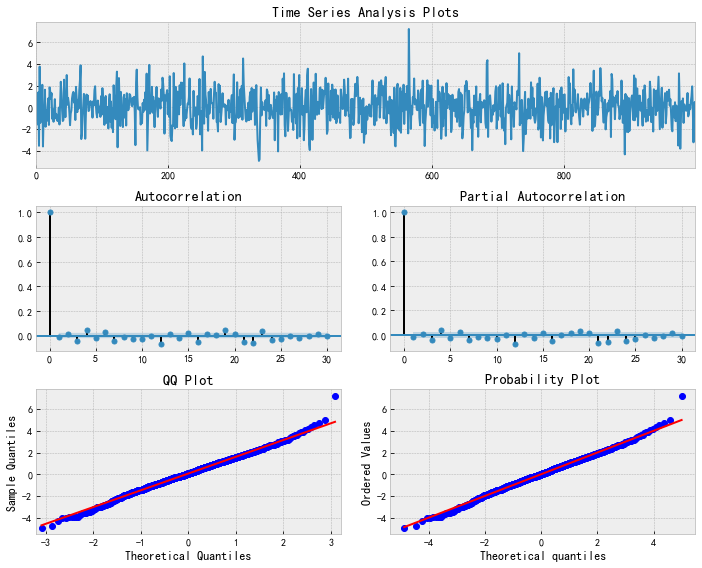

In [208]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(1)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH模型
Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)  

$$\varepsilon_t =\sigma_t\omega_t\\ \sigma_t^2 =\alpha_0+\alpha_1\varepsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

$\omega_t$为白噪音，$\alpha_1+\beta_1$必须小于1，否则模型将是非平稳的。

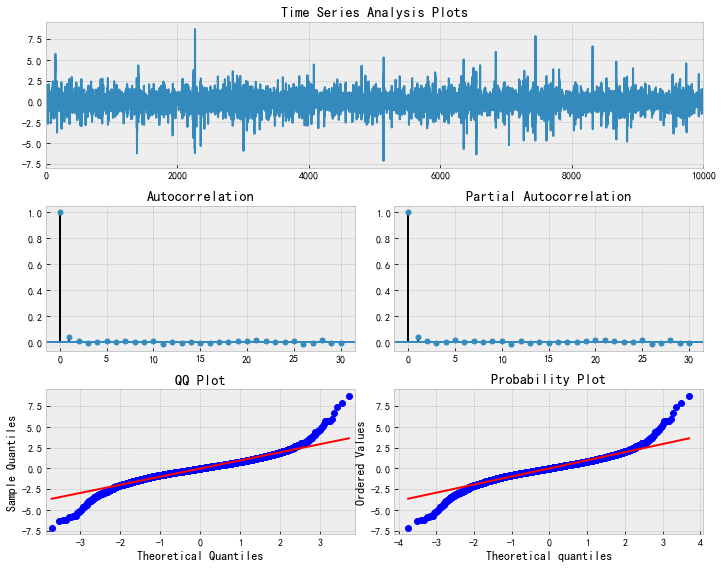

In [209]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

eps结果接近白噪音，再看看eps的平方

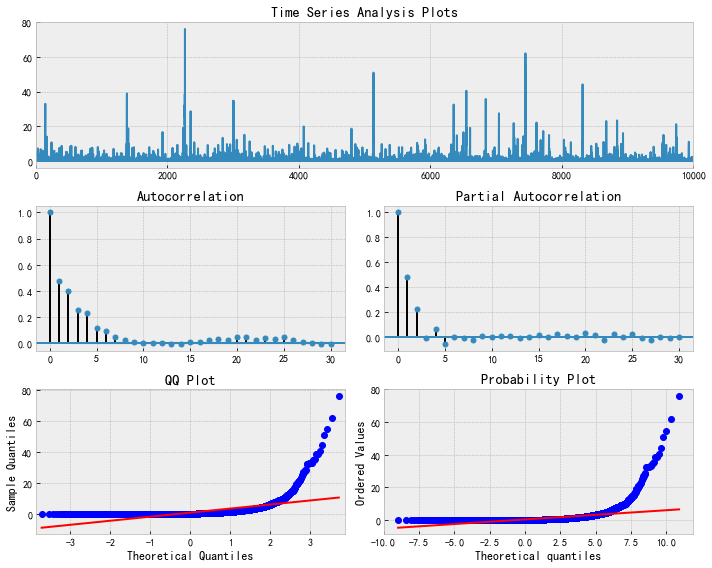

In [210]:
tsplot(eps**2, lags=30)

In [212]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Thu, Jun 06 2019   Df Residuals:                     9996
Time:      

In [218]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [221]:
# Notice I've selected a specific time period to run this analysis
TS = logret.values
res_tup = _get_best_model(TS)

aic: -18419.37745 | order: (4, 0, 4)


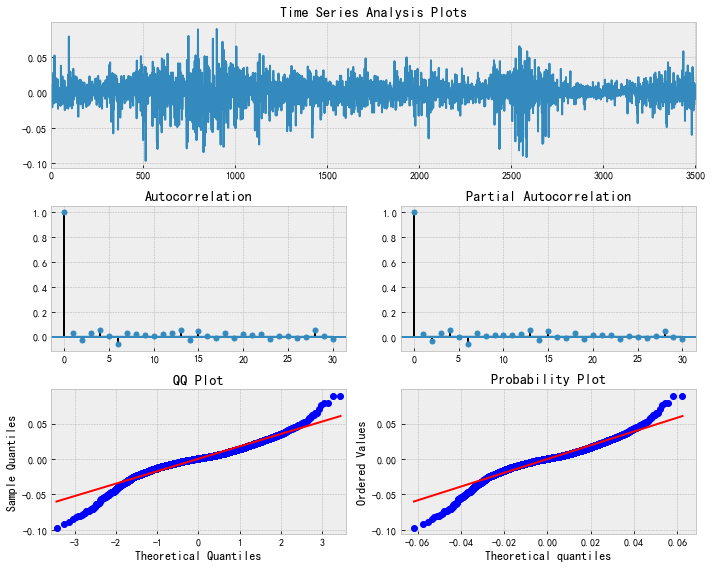

In [223]:
tsplot(TS, lags=30)

Squared residuals show autocorrelation. Let's fit a GARCH model and see how it does. 

In [233]:
# Now we can fit the arch model using the best fit arima model parameters
order=res_tup[1]
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                6641.80
Distribution:      Standardized Student's t   AIC:                          -13261.6
Method:                  Maximum Likelihood   BIC:                          -13193.8
                                              No. Observations:                 3503
Date:                      Thu, Jun 06 2019   Df Residuals:                     3492
Time:                              18:11:07   Df Model:                           11
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

C:\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


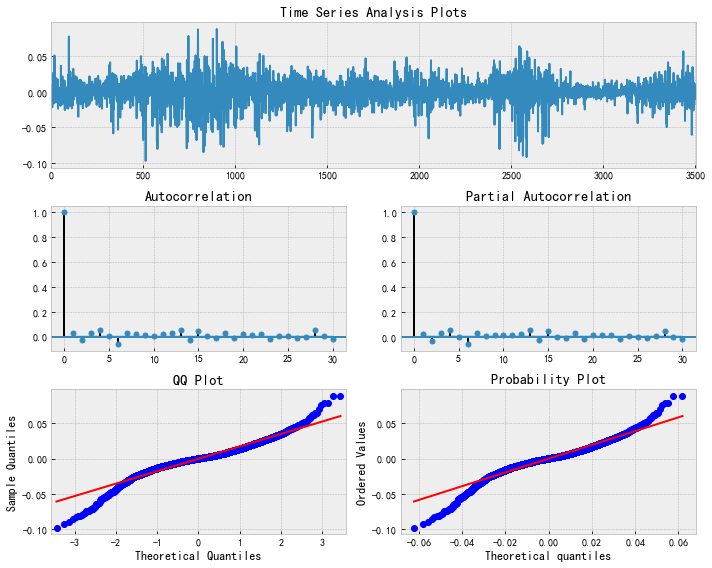

In [231]:
tsplot(res.resid, lags=30)